Summary
============

This is the summary of all the methods I attempted for this project. The goal was to try out some basic classification algorithms in machine learning and become familiar with the workflow and package set up of sklearn. In that regard, the project was a success. The actual results for the "Santander Customer Transaction Prediction" competition were a test score around 0.73 on kaggle. 

The final method I settled on was using a random forest classifier with weighted training and predictions. The method had to be coded by subclassing the sklearn ensemble class (`skensemble.BaggingClassifier`). The weighted random forest idea was taken directly from the work of Chao Chen, Andy Liaw, and Leo Breiman entitled "Using Random Forest to Learn Imbalanced Data". 



In [1]:
# Load the methods for analysis
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import sklearn #SciKit-learn, good ML package
from sklearn.externals import joblib #for dumping and loading learned classifiers
from sklearn import tree as sktree
from sklearn.decomposition import PCA as skPCA
import os
import time
import matplotlib.pyplot as plt

from load import DataWorker #custom class for working with the data worker
from decision_tree_ensemble import get_new_predictions, WeightedPredictionEnsemble

cwd = os.getcwd()
ld = DataWorker() #load the data into the class

work_dir = "%s/ensemble_decision_tree" % cwd



Initial Analysis
----------------------

The problem itself is relatively simple. There are 200 dimensions to the data, and 200k training samples and 200k test samples. The training set however is imbalanced such that 90% of the training data gives 0 (no transaction) while 10% of the training data gives 1 (yes transaction). However, analysis of the submitted solutions to kaggle suggest that the test sample is closer to a 50/50 split of predicted targets. Thus, overfitting is extremely easy, and the classifiers can become biased to avoid misclassifying 0's (majority state) instead of correctly identify the 1's (minority state).

In [2]:
print("Size of training set: %d" % ld.n_training)
print("Number of input dimensions: %d" % ld.n_inputs)
print("Size of test set: %d" % ld.n_tests)

a_zeros, a_ones = ld.find_number_classified(ld.targets)
print("Training set: %f are zeroes" % (a_zeros / (a_zeros + a_ones))) #percentage of zeros in the training set


Size of training set: 200000
Number of input dimensions: 200
Size of test set: 200000
Training set: 0.899510 are zeroes


We can also show that there is very little correlation between the 200 dimensions of the training data suggesting that all 200 variables are likely to be independent of each other and not coupled (at least linearly).

In [3]:
R = np.corrcoef(ld.training, rowvar=False) # calculate correlation coefficient between all dimensions
assert np.shape(R)[0] == ld.n_inputs

# zero out the diagonal, since of course it's 1!
for i in range(ld.n_inputs):
    R[i,i] = 0

print("largest correlation coefficient: %f" % np.max(np.abs(R)))

largest correlation coefficient: 0.009844


Finally, we can try to see how the distribution of 1's and 0's are in some space. Because, plotting all 200 dimensions would be hard for the human mind to process, I use some PCA to just see what the biggest variance directions show. What we find is that the target 1 and 0 results are very well mixed. This would explain why a method like SVM failed as it can't define a simple hyper-plane separating the 1's and 0's.

In [4]:
pca = skPCA(n_components=2)
pca.fit(ld.training)
coords = pca.transform(ld.training)

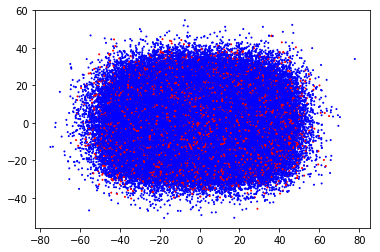

In [5]:
color_sequence = []
for value in ld.targets:
    if value == 0:
        col = "b"
    else:
        col = "r"
    color_sequence.append(col)

plt.figure()
plt.scatter(coords[:,0], coords[:,1], s=1, c=color_sequence)

Weighted Random Forest
----------------------

As previously mentioned, a random forest classifier was used to predict the likelihood of a customer making a transaction. Two other methods were attempted prior to settling on a random forest. A regular decision tree overfits the training data significantly, and failed to predict many of the transactions. A SVM failed to find any satisfactory division between 1 and 0 (Though this could be due to the fact that the data set was too large to be computed in a reasonable time on my machine).

With the random forest, the minority data is re-weighted so that it effectively gets counted more during training. Also, the final voting by the trees is such that any vote for the minority state is equally weighted. Chen, Liaw and Breiman found that this:
1. Effectively replicated the effect of re-sampling the training data so that there's a more equal number of minority and majority training data.
2. Prevented over-fitting to be biased to predicting the majority data set. 

The final random forest that was settled on used 30k randomly sampled (with replacement) states from the training data for each tree. Each tree was then fitted with a minimum sample split of 2 (go to completion), using 40 random features at each split with a class-weight of 7:1 for the minority:majority state. 200 trees were trained. 

In [6]:
rfclf = joblib.load("%s/RFclf.pkl" % work_dir)
results = rfclf.predict(ld.tests)
zeros, ones = ld.find_number_classified(results)
print("Found: %f are zeroes" % (zeros / (zeros + ones))) #percentage of zeros in the test set

Found: 0.737675 are zeroes


Cross Validation Scores
-----------------------------------

The final hyper parameters, `max_features`, `max_samples` and `weight_one`, were determined by computing the cross validation score. For a random forest, it's been well established that more trees generally leads to a better result. Empirically, I found the ideal number of trees to be somewhere between 100 to 1000 (only marginal improvement getting to 1000 trees). 

In [7]:
params = ["max_features", "max_samples", "max_samples_100trees", "weight_one", "weight_one_small"]
column = [2, 1, 1, 3, 3]

In [8]:
# load and compute averages and standard deviation for each kernel's CV score
all_cvalues = []
all_cv_avgs = []
all_cv_sd = []

for idx,i_param in enumerate(params):
    all_cvalues.append(np.loadtxt("%s/cv_%s_values.dat" % (work_dir, i_param))[:,column[idx]])
    cv_scores = np.loadtxt("%s/cv_%s_scores.dat" % (work_dir, i_param))
    all_cv_avgs.append(cv_scores.mean(axis=1)) #I can't believe it took me 4 years to learn this trick
    all_cv_sd.append(cv_scores.std(axis=1))

    

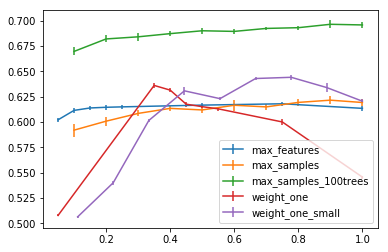

In [9]:
# plot the results
plt.figure()
for i in range(5):
    plt.errorbar(all_cvalues[i] / np.max(all_cvalues[i]), all_cv_avgs[i], all_cv_sd[i], label=params[i])

plt.legend(loc="lower right")

`max_samples` is the number of sampels to draw for each decision tree in the forest. In general, the improvement is relatively small with increasing number of samples after 30k samples for each tree, approximately, 15% of the total training set. One consideration was that as the number of samples increases, the computation time increases linearlly as well. Given that the CV score increases gradually after 30k samples, but increases significantly with increasing tree number, I decided it was better to have 30k samples with more trees, than 200k samples with fewer trees.

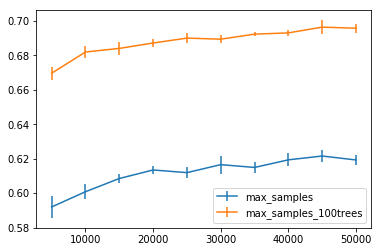

In [10]:
plt.figure()
for i in [1,2]:
    plt.errorbar(all_cvalues[i], all_cv_avgs[i], all_cv_sd[i], label=params[i])
plt.legend(loc="lower right")


`max_features` is the number of features to considerat each node of the decision tree when deciding to split the node further. This also increases the computation time linearly with the number of features. However, the results ended up being relatively insensitive to the number of features so 40 was used. 

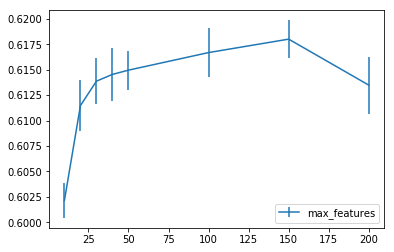

In [11]:
plt.figure()
for i in [0]:
    plt.errorbar(all_cvalues[i], all_cv_avgs[i], all_cv_sd[i], label=params[i])
plt.legend(loc="lower right")

`weight_one` is the extra weight to give to the minority classification. I would've expected the ideal weight to be 9, so that the total weight of the minority and majority samples would be equal. However, the CV score clearly shows that around 7 is the ideal weight. This is what I ended up using for the final classifier

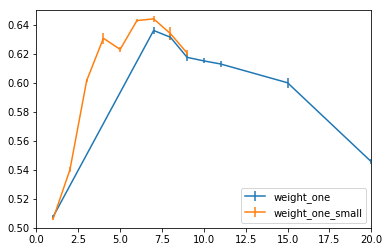

In [12]:
plt.figure()
for i in [3,4]:
    plt.errorbar(all_cvalues[i], all_cv_avgs[i], all_cv_sd[i], label=params[i])
plt.axis([0, 20, 0.5, 0.65])
plt.legend(loc="lower right")